In [1]:
 #from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda, Multiply,GlobalAveragePooling2D
from keras import backend as K
import cv2, numpy as np
import glob
from keras.optimizers import SGD, Adam
from keras.activations import relu 
import keras as keras
from keras.models import Model,load_model
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,add,Reshape

from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose,DepthwiseConv2D,Concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import losses
from keras.layers import  Layer,Activation, Lambda, MaxPooling2D, UpSampling2D, Conv2DTranspose, SpatialDropout2D
import os
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping 
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from  sklearn.model_selection import train_test_split

#from tensorflow.python import debug as tf_debug
import imageio
import glob
from skimage import transform as tf
from keras.losses import mse, binary_crossentropy


from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import scipy
import scipy
import skimage
import re
#import LRFinder
import math as m
import tensorflow as tf 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler 
from keras import backend as K
from pathlib import Path
from keras import objectives

from keras import optimizers

import numpy as np
 
from keras import backend as K
from skimage.measure import compare_ssim, compare_psnr

from keras.utils import to_categorical

import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

tf.random.Generator = None 
import tensorflow_addons as tfa
from keras.datasets import  mnist, fashion_mnist

import warnings
warnings.filterwarnings('ignore')
from keras.models import Model
from keras.utils import to_categorical


from datetime import datetime
from scipy.fftpack import dct, idct
import copy

Using TensorFlow backend.


In [2]:
(x_train, y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
print(len(x_train), len(y_train),  len(X_test), len(Y_test))

50000 50000 10000 10000


In [4]:
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
Y_test = to_categorical(Y_test)

print(y_train.shape, Y_test.shape)

(50000, 10) (10000, 10)


In [5]:
image_size = x_train.shape[1]

x_train = np.reshape(x_train,[-1, image_size, image_size, 3])
X_test = np.reshape(X_test,[-1, image_size, image_size, 3])

x_train = x_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print(x_train.shape, X_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [6]:
 
x_val=X_test[:8000]
y_val=Y_test[:8000]
x_test=X_test[8001:]
y_test=Y_test[8001:]

In [7]:
# network parameters
input_shape = (image_size, image_size, 3)
batch_size = 128
kernel_size = 3
filters = 64
dropout = 0.3

In [8]:
def conv_block(units, dropout=0.2, activation='relu', block=1, layer=1):

    def layer_wrapper(inp):
        x = Conv2D(units, (3, 3), padding='same', name='block{}_conv{}'.format(block, layer))(inp)
        x = BatchNormalization(name='block{}_bn{}'.format(block, layer))(x)
        x = Activation(activation, name='block{}_act{}'.format(block, layer))(x)
        x = Dropout(dropout, name='block{}_dropout{}'.format(block, layer))(x)
        return x

    return layer_wrapper

def dense_block(units, dropout=0.2, activation='relu', name='fc1'):

    def layer_wrapper(inp):
        x = Dense(units, name=name)(inp)
        x = BatchNormalization(name='{}_bn'.format(name))(x)
        x = Activation(activation, name='{}_act'.format(name))(x)
        x = Dropout(dropout, name='{}_dropout'.format(name))(x)
        return x

    return layer_wrapper
        

def VGG16_BN(input_tensor=None, input_shape=None, classes=1000, conv_dropout=0.1, dropout=0.3, activation='relu'):
    """Instantiates the VGG16 architecture with Batch Normalization
    # Arguments
        input_tensor: Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
        input_shape: shape tuple
        classes: optional number of classes to classify images
    # Returns
        A Keras model instance.
    """
    img_input = Input(shape=input_shape) if input_tensor is None else (
        Input(tensor=input_tensor, shape=input_shape) if not K.is_keras_tensor(input_tensor) else input_tensor
    )

    # Block 1
    x = conv_block(32, dropout=conv_dropout, activation=activation, block=1, layer=1)(img_input)
    x = conv_block(32, dropout=conv_dropout, activation=activation, block=1, layer=2)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = conv_block(64, dropout=conv_dropout, activation=activation, block=2, layer=1)(x)
    x = conv_block(64, dropout=conv_dropout, activation=activation, block=2, layer=2)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=1)(x)
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=2)(x)
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=1)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=2)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=1)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=2)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Flatten
    x = GlobalAveragePooling2D()(x)

    # FC Layers
    x = dense_block(512, dropout=dropout, activation=activation, name='fc1')(x)
    x = dense_block(512, dropout=dropout, activation=activation, name='fc2')(x)
    
    # Classification block    
    x = Dense(classes, activation='softmax', name='predictions')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    inputs = get_source_inputs(input_tensor) if input_tensor is not None else img_input

    # Create model.
    return Model(inputs, x, name='vgg16_bn')

In [9]:
from keras.models import Model

inputs = Input(shape=input_shape)
y = Conv2D(filters=filters,kernel_size=kernel_size,activation='relu')(inputs)
y = MaxPooling2D()(y)
y = Conv2D(filters=filters,kernel_size=kernel_size,activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=filters,kernel_size=kernel_size,activation='relu')(y)
 
y = Flatten()(y)
 
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

 
model = Model(inputs=inputs, outputs=outputs)

 
#model =VGG16_BN(input_tensor=None, input_shape=x_train.shape[1:], classes=10, conv_dropout=0.1, dropout=0.3, activation='relu')
 
#model.summary()

In [10]:
 
from adam_or import Aadam
from Ada_mod import Adamod

In [11]:
fw=model.get_weights()

In [12]:
ep=30
lra=[5e-3,1e-3,5e-4,1e-4]
optimizer = Adamod()


weights_dict = {}

weight_callback = tf.keras.callbacks.LambdaCallback \
( on_epoch_end=lambda epoch, logs: weights_dict.update({epoch:model.get_weights()}))


model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
 


hb1=model.fit(x_train,y_train, epochs=ep, validation_data=(x_test, y_test), callbacks = [weight_callback  ])

Train on 50000 samples, validate on 1999 samples
Epoch 1/30
50000/50000 [==============================] - 9s 179us/step - loss: 1.6136 - accuracy: 0.4061 - val_loss: 1.2919 - val_accuracy: 0.5418
Epoch 2/30
50000/50000 [==============================] - 8s 159us/step - loss: 1.2157 - accuracy: 0.5673 - val_loss: 1.0679 - val_accuracy: 0.6273
Epoch 3/30
50000/50000 [==============================] - 8s 161us/step - loss: 1.0631 - accuracy: 0.6262 - val_loss: 1.0083 - val_accuracy: 0.6483
Epoch 4/30
50000/50000 [==============================] - 8s 161us/step - loss: 0.9685 - accuracy: 0.6631 - val_loss: 0.9489 - val_accuracy: 0.6678
Epoch 5/30
50000/50000 [==============================] - 8s 159us/step - loss: 0.8994 - accuracy: 0.6850 - val_loss: 0.9330 - val_accuracy: 0.6708
Epoch 6/30
50000/50000 [==============================] - 8s 158us/step - loss: 0.8507 - accuracy: 0.7030 - val_loss: 0.9078 - val_accuracy: 0.6823
Epoch 7/30
50000/50000 [==============================] - 8s 15

In [13]:
# fw=model.get_weights()
# model2=model

# model2.set_weights(fw)

In [14]:
model2=  Model(inputs=inputs, outputs=outputs)
optimizer = Aadam()
model2.set_weights(fw)

weights_dict = {}

weight_callback = tf.keras.callbacks.LambdaCallback \
( on_epoch_end=lambda epoch, logs: weights_dict.update({epoch:model.get_weights()}))


model2.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
 


hb2=model2.fit(x_train,y_train, epochs=ep, validation_data=(x_test, y_test), callbacks = [weight_callback  ])

Train on 50000 samples, validate on 1999 samples
Epoch 1/30
50000/50000 [==============================] - 8s 157us/step - loss: 1.6061 - accuracy: 0.4136 - val_loss: 1.2874 - val_accuracy: 0.5393
Epoch 2/30
50000/50000 [==============================] - 8s 152us/step - loss: 1.2730 - accuracy: 0.5464 - val_loss: 1.1224 - val_accuracy: 0.5918
Epoch 3/30
50000/50000 [==============================] - 8s 153us/step - loss: 1.1444 - accuracy: 0.5964 - val_loss: 1.1022 - val_accuracy: 0.6013
Epoch 4/30
50000/50000 [==============================] - 8s 154us/step - loss: 1.0560 - accuracy: 0.6280 - val_loss: 1.0866 - val_accuracy: 0.6143
Epoch 5/30
50000/50000 [==============================] - 8s 154us/step - loss: 0.9956 - accuracy: 0.6498 - val_loss: 0.9714 - val_accuracy: 0.6648
Epoch 6/30
50000/50000 [==============================] - 8s 154us/step - loss: 0.9450 - accuracy: 0.6696 - val_loss: 0.9721 - val_accuracy: 0.6588
Epoch 7/30
50000/50000 [==============================] - 8s 15

In [15]:
h1=hb1.history['accuracy']
h2=hb2.history['accuracy']

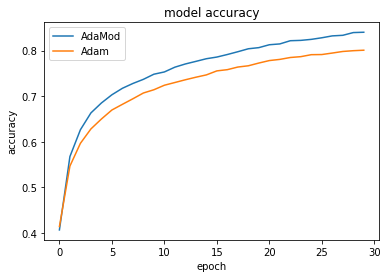

In [16]:
plt.plot(h1)
plt.plot(h2)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['AdaMod', 'Adam'], loc='upper left')
plt.show()

In [17]:
vh1=hb1.history['val_accuracy']
vh2=hb2.history['val_accuracy']

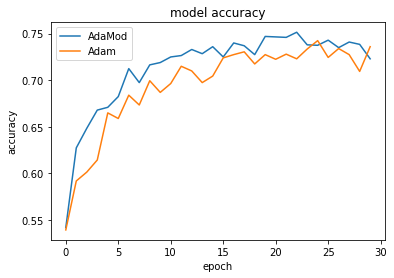

In [18]:
plt.plot(vh1)
plt.plot(vh2)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['AdaMod', 'Adam'], loc='upper left')
plt.show()